In [2]:
import numpy as np 
import pandas as pd
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers, Input
from keras.layers import InputLayer, MaxPooling2D, Flatten, Dense, Conv2D, Dropout
from keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from PIL.Image import open

from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import random
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp "/content/drive/MyDrive/Brain Tumor" "/content/"
!cp "/content/drive/MyDrive/Brain Tumor/Brain Tumor" "/content/"
!cp "/content/drive/MyDrive/Brain Tumor/Brain Tumor.csv" "/content/"

cp: -r not specified; omitting directory '/content/drive/MyDrive/Brain Tumor'
cp: -r not specified; omitting directory '/content/drive/MyDrive/Brain Tumor/Brain Tumor'


In [5]:
IMAGE_DATASET = "/content/drive/MyDrive/Brain Tumor/Brain Tumor"
IMAGE_DATASET_RAW = r"\content\drive\MyDrive\Brain Tumor\Brain Tumor"
WORKING_FOLDER = "/content/drive/MyDrive/Brain Tumor"
IMG_HEIGHT = 224
IMG_WIDTH = 224
EPOCHS = 50

In [6]:
cortex_df = pd.read_csv("/content/drive/MyDrive/Brain Tumor/Brain Tumor.csv")
cortex_df.head()

,Image,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,Image1,0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
1,Image2,0,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
2,Image3,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
3,Image4,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
4,Image5,0,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155


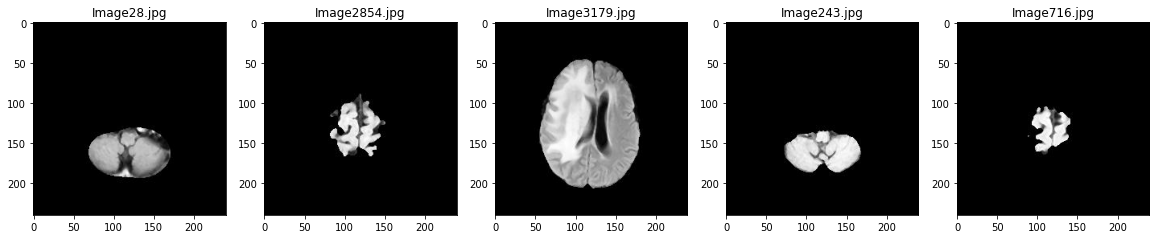

In [7]:
plt.figure(figsize=(20,20))
test_folder="/content/drive/MyDrive/Brain Tumor/Brain Tumor" 
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

In [8]:
dataset_df = pd.DataFrame()
dataset_df["Image"] = cortex_df["Image"]
dataset_df["Class"] = cortex_df["Class"]
path_list = []
for img_path in os.listdir(IMAGE_DATASET):
    path_list.append( os.path.join(IMAGE_DATASET,img_path))
path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in path_list}
dataset_df["paths"] = cortex_df["Image"].map(path_dict.get)
dataset_df["pixels"] = dataset_df["paths"].map(lambda x:np.asarray(open(x).resize((IMG_HEIGHT,IMG_WIDTH))))
dataset_df.head()

,Image,Class,paths,pixels
0,Image1,0,/content/drive/MyDrive/Brain Tumor/Brain Tumor...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,Image2,0,/content/drive/MyDrive/Brain Tumor/Brain Tumor...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,Image3,1,/content/drive/MyDrive/Brain Tumor/Brain Tumor...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,Image4,1,/content/drive/MyDrive/Brain Tumor/Brain Tumor...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,Image5,0,/content/drive/MyDrive/Brain Tumor/Brain Tumor...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [9]:
image_list = []
for i in range(len(dataset_df)):
    brain_image = dataset_df["pixels"][i].astype(np.float32)
    brain_image /= 255
    image_list.append(brain_image)
X = np.array(image_list)
print(X.shape)

(3762, 224, 224, 3)


In [10]:
y = np.array(dataset_df.Class)
y.shape 

(3762,)

In [11]:
def split_data(X, y, test_size=0.2):
       
   # Splits data into training, development and test sets.
  
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [12]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [13]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 2633
number of development examples = 565
number of test examples = 564
X_train shape: (2633, 224, 224, 3)
Y_train shape: (2633,)
X_val (dev) shape: (565, 224, 224, 3)
Y_val (dev) shape: (565,)
X_test shape: (564, 224, 224, 3)
Y_test shape: (564,)


In [14]:
def model(input_shape):

    model = Sequential()
    
    model.add(Input(shape=input_shape))
    
    model.add(Conv2D(16, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(16, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
            
    model.add(Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
    
    model.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dense(128, activation="relu"))

    model.add(Dense(1, activation="sigmoid"))   
    
    return model

In [15]:
model = model(input_shape = (IMG_HEIGHT, IMG_WIDTH, 3))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                    

In [17]:
optimizer = SGD(learning_rate=0.01)
loss_fn = BinaryCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [18]:
history = model.fit(x=X_train, y=y_train, batch_size=10, epochs=EPOCHS, validation_data=(X_val, y_val))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


264/264 [==============================] - 25s 92ms/step - loss: 0.6042 - accuracy: 0.6783 - val_loss: 0.5735 - val_accuracy: 0.7274
Epoch 2/50
264/264 [==============================] - 24s 91ms/step - loss: 0.5010 - accuracy: 0.7668 - val_loss: 0.5288 - val_accuracy: 0.7469
Epoch 3/50
264/264 [==============================] - 24s 91ms/step - loss: 0.4764 - accuracy: 0.7828 - val_loss: 0.6441 - val_accuracy: 0.7133
Epoch 4/50
264/264 [==============================] - 24s 91ms/step - loss: 0.4440 - accuracy: 0.8082 - val_loss: 0.4331 - val_accuracy: 0.8000
Epoch 5/50
264/264 [==============================] - 24s 92ms/step - loss: 0.4059 - accuracy: 0.8226 - val_loss: 0.4851 - val_accuracy: 0.7841
Epoch 6/50
264/264 [==============================] - 25s 93ms/step - loss: 0.3837 - accuracy: 0.8359 - val_loss: 0.4411 - val_accuracy: 0.7805
Epoch 7/50
264/264 [==============================] - 24s 91ms/step - loss: 0.3434 - accuracy: 0.8519 - val_loss: 0.3288 - val_accuracy: 0.8708
Epo

In [19]:
model.save("/content/drive/MyDrive/Brain Tumor/model_braintumorv7.h5")

In [20]:
history = model.history.history

In [21]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [22]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

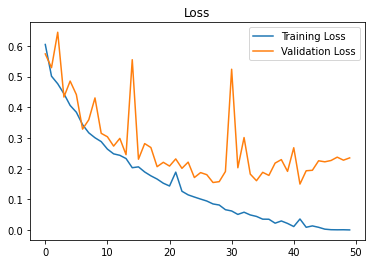

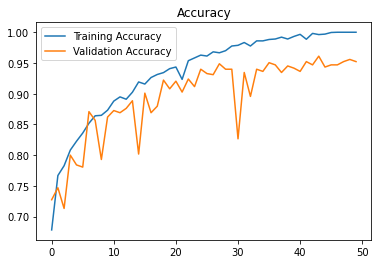

In [23]:
plot_metrics(history)

In [24]:
eval_score = model.evaluate(X_test, y_test)
print("Test loss:", eval_score[0])
print("Test accuracy:", eval_score[1])

18/18 [==============================] - 1s 82ms/step - loss: 0.3463 - accuracy: 0.9504
Test loss: 0.34627166390419006
Test accuracy: 0.9503546357154846
